In [1]:
from sklearn import datasets, linear_model

from sklearn.model_selection import cross_val_predict, cross_val_score, validation_curve, train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error,r2_score

from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor

from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import shap
import featuretools as ft
from pdpbox import pdp, info_plots

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import os
import shutil

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
def plot_train_test(exp_value, predicted_value, R2_value, name):
    plt.scatter(exp_value, predicted_value)
    
    _min = exp_value.min() #- 500
    _max = exp_value.max() #+ 500

    plt.plot([_min, _max], [_min, _max], color="red", linestyle='--')

    text_x = np.min(exp_value) + (np.max(exp_value) - np.min(exp_value)) * 0.01
    text_y = np.max(predicted_value) - (np.max(predicted_value) - np.min(predicted_value)) * 0.01
    plt.text(text_x, text_y, f'$R^2$ = {R2_value:.2f}', fontsize=18, color='red')
    
    plt.xlabel("Actual value", fontsize=18)
    plt.ylabel("Predicted value", fontsize=18)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.minorticks_on()

    ax = plt.gca()  # 获取当前坐标轴
    ax.xaxis.set_minor_locator(MultipleLocator(100))  # 设置 x 轴次刻度的间隔
    ax.yaxis.set_minor_locator(MultipleLocator(100))  # 设置 y 轴次刻度的间隔

    plt.tick_params(axis='both', which='minor', length=2, color='gray', direction='out', labelsize=10)

    plt.xlim(_min, _max)
    plt.ylim(_min, _max)

    plt.tight_layout()
    plt.show()
    plt.savefig(name + ".png")
    plt.clf()

In [3]:

used_features = ['mol_volume', 'mol_polar_area', 'logP', 'num_h_donors', 'num_h_acceptors', 'estate_indices_std', 'estate_indices_mean', 'chi1v', 'bond_lengths_mean']

filename = "features_training.xlsx"

data_targets = pd.read_excel(filename,index_col=0)
data_features = data_targets.loc[:,"mol_weight":][used_features]

tar_homo = data_targets["HOMO_eV"]

target = "HOMO_eV"
X = data_features.values
y = tar_homo



In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.2,random_state=5)  # 5



# ML model

In [6]:
def rfr():

    rfr_para = {'n_estimators':350,    # 200 
                'random_state':2,      # 2
                'min_samples_leaf':3,  # 2 
                'min_samples_split':4, # 3
                'max_features':10,      # 5
                # 'min_weight_fraction_leaf':0.01,
                # 'max_depth':10,
                'n_jobs':-1
                }
    rfr = RandomForestRegressor(**rfr_para)
    
    return rfr

def gbr():
    gbr_para = {'n_estimators': 70, #300, 
            'max_features': 5, #4,
            'max_depth': 6,
            'min_samples_split': 2, #5,
            'min_samples_leaf': 1, # 3,
            'learning_rate': 0.1,
            'random_state': 2}

    gbr = GradientBoostingRegressor(**gbr_para)

    return gbr

def svr():

    svr_para = {'C':3,
        'kernel':"rbf",
        'gamma' : 0.2,
        'epsilon':0.01
        }

    pipeline = Pipeline([
    ('scaler', StandardScaler()),  #标准化步骤
    # ('scaler',MinMaxScaler()),       # 归一化
    ('svr',SVR(**svr_para))])

    return pipeline

def brg():
    brg = BaggingRegressor(estimator=None,
                        n_estimators=110,
                        max_samples=12,
                        max_features=9,
                        bootstrap=True,
                        bootstrap_features=False,
                        oob_score=False,
                        warm_start=False,
                        random_state=42,
                        verbose=0)
    return brg

def lgbm():
    lgbm = LGBMRegressor(n_estimators=160,
                        boosting_type='gbdt',
                        objective='regression',
                        # device= "gpu",
                        min_samples_split=2,
                        learning_rate=0.04,
                        random_state=0,
                        force_col_wise=True,
                        is_unbalance=True,
                        verbose=-1,
                        n_jobs=-1)
    return lgbm

def xgb():
    xgb = XGBRegressor(n_estimators=100,
                    reg_alpha = 0.1,
                    reg_lambda = 0.03,

                    # boosting_type='gbdt',
                    # objective='regression',
                    min_samples_split=2,
                    learning_rate=0.03,
                    random_state=0,
                    n_jobs=-1)
    return xgb

def kng():

    pipeline = Pipeline([
    ('scaler', StandardScaler()),  #标准化步骤
    # ('scaler',MinMaxScaler()),       # 归一化

    ('kng',KNeighborsRegressor(n_neighbors=12, 
                        weights="distance" , # "uniform", # 
                        algorithm= "auto", #"auto", 
                        leaf_size = 2,
                        p=1, 
                        metric="minkowski", 
                        metric_params=None)) 
    ])

    return pipeline

def nn():
    pipeline = Pipeline([
    ('scaler', StandardScaler()),  #标准化步骤
    # ('scaler',MinMaxScaler()),       # 归一化
    ('nn', MLPRegressor(random_state=2,
                  alpha=0.001,
                  activation='tanh',#'identity', #'relu',
                  solver='lbfgs', #'adam',
                  hidden_layer_sizes=(80,50),
                  max_iter=180))
    ])  
    
    return pipeline 

def cbr():
    cbr = CatBoostRegressor(iterations=300, # 迭代次数   #500
                            learning_rate=0.1,            # 学习率 0.03 
                            depth=8,                       # 树的深度 8
                            loss_function='RMSE',          # 损失函数
                            l2_leaf_reg=3.0,               # L2 正则化系数 1
                            random_strength=1.2,           # 随机性强度 1.5 
                            early_stopping_rounds=50,      # 早停 50
                            # use_best_model=True,           # 使用早停时的最佳模型
                            # # task_type='GPU',     
                            random_state=2,         
                            verbose=False                   # 不输出迭代日志
                        )
    return cbr

def running_10fold(ML_model, X_train, Y_train):
    # 创建 KFold 对象
    kf = KFold(n_splits=10, shuffle=True, random_state=2)

    ml_fit = ML_model.fit(X_train, Y_train)
    print(ml_fit)
    
    joblib.dump(ml_fit,"ml_model.pkl")

    cv_scores = cross_val_score(ml_fit, X_train, Y_train, cv=kf, scoring='r2')
    cv_rmse_scores = -cross_val_score(ml_fit, X_train, Y_train, cv=kf, scoring='neg_root_mean_squared_error')
    R2_value = np.mean(cv_scores)
    print(f"Cross-validation R2 scores: {cv_scores}")
    print(f"Mean CV R2: {np.mean(cv_scores):.3f}")
    print(f"Cross-validation RMSE scores: {cv_rmse_scores}")
    print(f"Mean CV RMSE: {np.mean(cv_rmse_scores):.3f}")
    
    # 记录每一折的预测值
    all_actuals = []
    all_predictions = []

    for fold, (train_index, test_index) in enumerate(kf.split(X_train), start=1):

        # print(f"Fold {fold}")
        # 使用 numpy 索引进行数据分割
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = Y_train.iloc[train_index], Y_train.iloc[test_index]
        
        # 训练模型并预测
        ML_model.fit(X_train_fold, y_train_fold)
        y_pred_fold = ML_model.predict(X_test_fold)
        
        # 保存实际值和预测值
        all_actuals.extend(y_test_fold)
        all_predictions.extend(y_pred_fold)
        
        # 输出每一折的实际值和预测值
        # print(f"Actual values: {y_test_fold.values}")
        # print(f"Predicted values: {y_pred_fold}")
        # print(f"Fold {fold} R2: {r2_score(y_test_fold, y_pred_fold):.3f}//n")
    
    # 转换为 numpy 数组，便于后续绘图
    all_actuals = np.array(all_actuals)
    all_predictions = np.array(all_predictions)
    
    plot_train_test(all_actuals, all_predictions, R2_value, "train")

    df_train = pd.concat([pd.DataFrame(all_actuals,columns=["Actual value"]), pd.DataFrame(all_predictions, columns=["Predicted value"])], axis=1)
    df_train.to_excel("training_actual_predicted.xlsx")

    return df_train

def run_test( X_test, Y_test): #ML_model, X_train, Y_train,

    test_actual = Y_test.reset_index(drop=True)
    test_actual.columns = ["Actual value"]

    # ml_fit = ML_model.fit(X_train, Y_train)
    ml_fit = joblib.load("ml_model.pkl")

    test_predicted_np = ml_fit.predict(X_test)

    test_predicted = pd.DataFrame(test_predicted_np, columns = ["Predicted value"])

    score_test = r2_score(test_predicted, Y_test)

    print(f'score of test_set: {score_test}')

    plot_train_test(Y_test, test_predicted, score_test, "test")

    df_test = pd.concat([test_actual,test_predicted], axis = 1)
    df_test.to_excel("test_actual_predicted.xlsx")

    return df_test

def SHAP_plot(ML_model,X_train,Y_train,feature_names):
    shap.initjs()
    clf = ML_model.fit(X_train, Y_train)
    # print(clf)
    explainer = shap.TreeExplainer(clf, X_train, feature_names=feature_names, check_additivity=False)
    shap_values = explainer(X_train)
    
    shap.plots.beeswarm(shap_values,max_display = 20)
    shap.plots.bar(shap_values,max_display=20)

def verification(X_verification, Y_verification): #ML_model, X_train, Y_train, 

    # ml_fit = ML_model.fit(X_train, Y_train)
    ml_fit = joblib.load("ml_model.pkl") 

    test_verification_np = ml_fit.predict(X_verification)

    score_verification = r2_score(test_verification_np, Y_verification)

    X_verification["Predicted"] = list(test_verification_np)
    X_verification.to_excel("predicted_value_verificaton.xlsx")

    print(score_verification)

    plot_train_test(Y_verification, test_verification_np, score_verification, "verification")

def features_importance(used_features):

    # clf = ML_model.fit(X_train, Y_train)
    # importances = clf.feature_importances_
    # print(importances)

    clf = joblib.load("ml_model.pkl")

    result = permutation_importance(clf, X_test, Y_test, n_repeats=10, random_state=0)
    importance = result.importances_mean

    features_list = []
    for feature_name, score_ in zip(used_features,importance):
        # print(f"Feature: {feature_name}, Importance: {score_}")
        features_list.append([feature_name, score_])

    score_pd = pd.DataFrame(features_list, columns=["Name", "Score"]).sort_values(by='Score', ascending=False)

    score_pd.to_excel("importance.xlsx")
    
    return score_pd



RandomForestRegressor(max_features=10, min_samples_leaf=3, min_samples_split=4,
                      n_estimators=350, n_jobs=-1, random_state=2)
Cross-validation R2 scores: [0.77590605 0.76350387 0.78221246 0.87326403 0.87659844 0.82749973
 0.7736914  0.87386591 0.79907535 0.83648866]
Mean CV R2: 0.818
Cross-validation RMSE scores: [0.31076931 0.33146059 0.33175633 0.24308041 0.26120739 0.27262964
 0.30087432 0.24642122 0.25362866 0.26244042]
Mean CV RMSE: 0.281


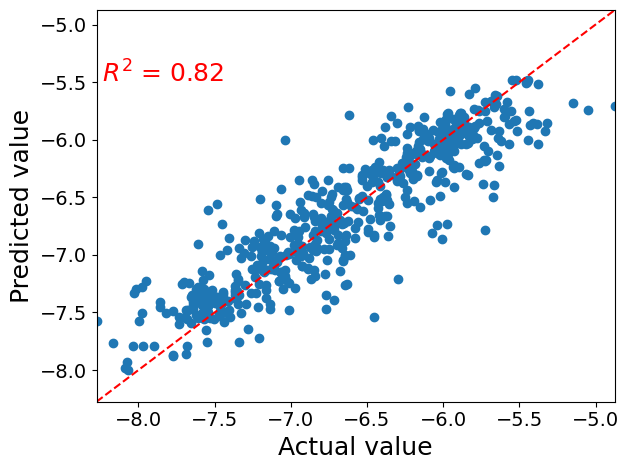

score of test_set: 0.8216667387761145


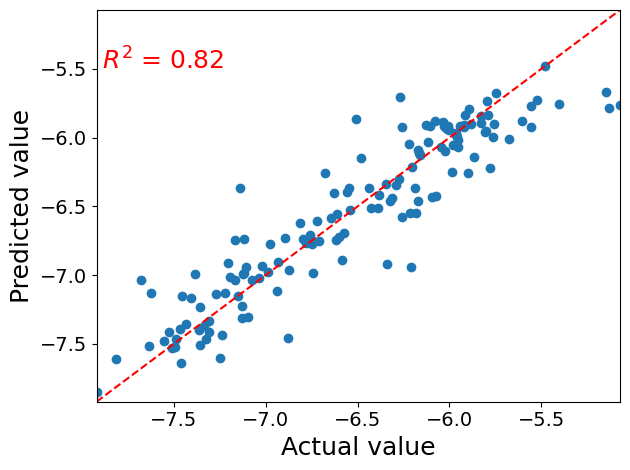

<Figure size 640x480 with 0 Axes>

In [11]:
ML_model = rfr()  # kng # nn # xgb # lgbm # brg # svr # rfr # gbr

df_train = running_10fold(ML_model, X_train, Y_train)

df_test = run_test(X_test, Y_test) #ML_model, X_train, Y_train, 

importance_pd = features_importance(used_features)



# Feature anlysis

#### SHAP value

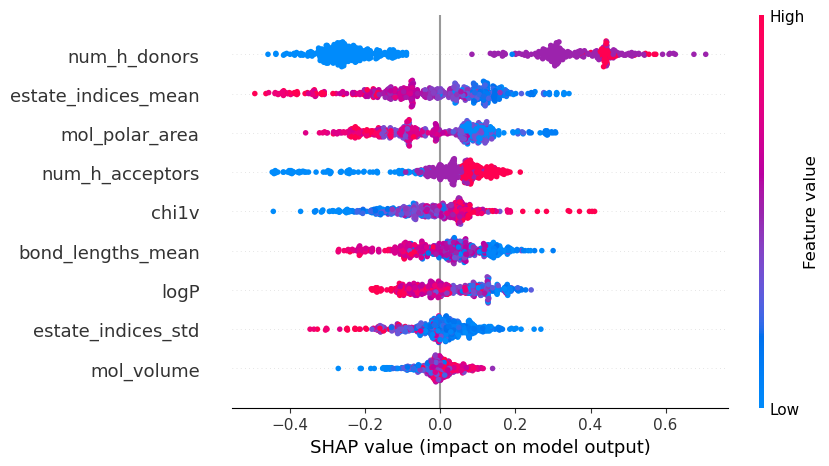

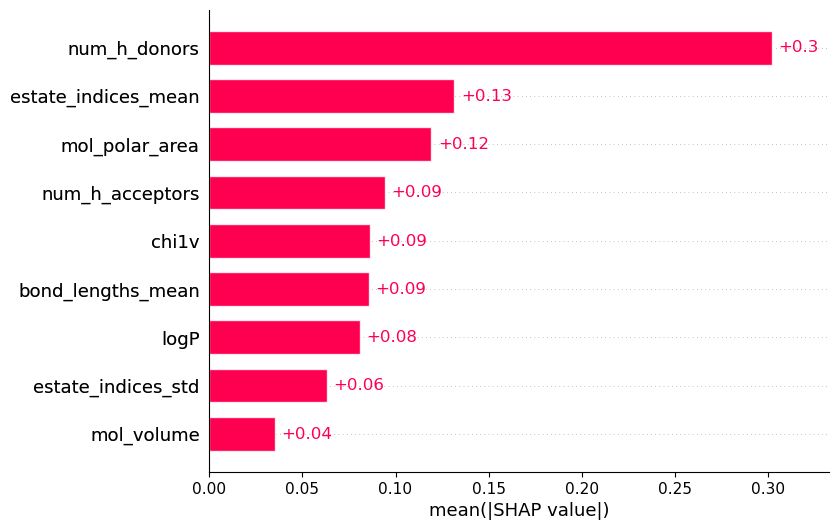

In [146]:
SHAP_plot(ML_model,X_train,Y_train,used_features)

### Calculate RMSD

In [134]:
import os
from openbabel import openbabel
import pandas as pd
import pybel

mol_path1 = "D://all_pm6//"
mol_path2 = "D://all_b3lyp//"

def calculate_rmsd(file1, file2):
    
    obConversion = openbabel.OBConversion()
    obConversion.SetInFormat("mol")

    # read the first molecule 
    mol1 = openbabel.OBMol()
    obConversion.ReadFile(mol1, file1)

    # read the second molecule 
    mol2 = openbabel.OBMol()
    obConversion.ReadFile(mol2, file2)

    # calculate RMSD
    aligner = openbabel.OBAlign()
    aligner.SetRefMol(mol1)  # reference
    aligner.SetTargetMol(mol2)  # target

    if aligner.Align():  # test
        rmsd = aligner.GetRMSD()
        return rmsd
    else:
        raise ValueError("Error, can not calculate RMSD")

# Get all mol files
mol_files_ = [i for i in os.listdir(mol_path1) if i.endswith(".mol")]

rmsd_list = []

for index_, mol_i in enumerate(mol_files_):
    
    print(f'{index_+1}/{len(mol_files_)},{mol_i}')
    
    file1 = os.path.join(mol_path1, mol_i)
    file2 = os.path.join(mol_path2, mol_i)

    try:
        
        rmsd = calculate_rmsd(file1, file2)

    except Exception as e:
        print(f"Structure {mol_i} Error: {e}")
    else:
        
        rmsd_list.append([int(mol_i.split(".")[0]), rmsd])

        if rmsd >= 2:
            print(f'rmsd more than 2: {mol_i}')



rmsd_pd = pd.DataFrame(rmsd_list,columns= ["Name","RMSD"])
# rmsd_pd.to_excel("rmsd.xlsx")
#plt.hist(rmsd_pd[0], bins=50, edgecolor='black')
# plt.scatter(rmsd_pd.index, rmsd_pd[0])
#plt.show()



1/821,100.mol
2/821,1000.mol
3/821,1001.mol
4/821,1002.mol
5/821,1003.mol
6/821,1004.mol
7/821,1005.mol
8/821,1006.mol
9/821,1007.mol
10/821,1008.mol
11/821,1009.mol
12/821,101.mol
13/821,1010.mol
14/821,1011.mol
15/821,1012.mol
16/821,1013.mol
17/821,1014.mol
18/821,1015.mol
19/821,1016.mol
20/821,1017.mol
21/821,1018.mol
22/821,1019.mol
23/821,102.mol
24/821,1021.mol
25/821,1022.mol
26/821,1023.mol
27/821,1024.mol
28/821,1025.mol
29/821,1026.mol
30/821,1027.mol
31/821,1028.mol
32/821,1029.mol
33/821,103.mol
34/821,1030.mol
35/821,1031.mol
36/821,1032.mol
37/821,1033.mol
38/821,1034.mol
39/821,1035.mol
40/821,1036.mol
41/821,1037.mol
42/821,1038.mol
43/821,1039.mol
44/821,104.mol
45/821,1040.mol
46/821,1041.mol
47/821,1042.mol
48/821,1043.mol
49/821,1045.mol
50/821,1046.mol
51/821,1047.mol
52/821,1048.mol
53/821,1049.mol
54/821,105.mol
55/821,1050.mol
56/821,1051.mol
57/821,1052.mol
58/821,1053.mol
59/821,1054.mol
60/821,1055.mol
61/821,1056.mol
62/821,1057.mol
63/821,1058.mol
64/821,